## While My MCMC Gently Samples
Bayesian modeling, Computational Psychiatry, and Python

Un blog de  Thomas Wiecki: http://twiecki.github.io/


## MCMC sampling for dummies

In [1]:
#load required modules

%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

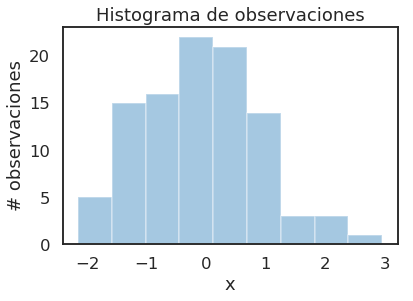

In [4]:
#generación de 100 puntos de una distribución normal de media 0 y varianza 1
#probar para distinto número muestras

data = np.random.randn((100))
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histograma de observaciones', xlabel='x', ylabel='# observaciones');

# # Modelo
Nuestro modelo está dado por
$$\mu \sim \text{Normal}(0, 1)$$
$$x | \mu \sim \text{Normal}(x ; \mu, 1)$$
En este caso, la posterior es conocida en forma cerrada, pues (i) modelo es gaussiano en $\mu$, (ii) la distribución posterior de $\mu$ también es gaussiana y (iii) las gaussianas son prior conjugadas. Con esto entonces podemos calcular la poserior en forma cerrada:


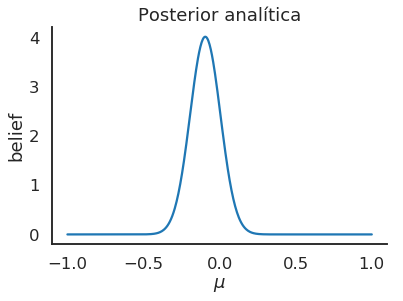

In [5]:
#computar la posterior en forma cerrada
#probar para distinto número de muestras

def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='$\mu$', ylabel='belief', title='Posterior analítica');
sns.despine()

## Markov chain Monte Carlo
Ahora veremos cómo aproximar numéricamente esta distribución, lo cual va a ser útil en los casos que no la podemos calcular en forma cerrada. 

Primero definimos la función "sampler":

In [6]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0.0, mu_prior_sd=1.0):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior

# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    #plt.legend()

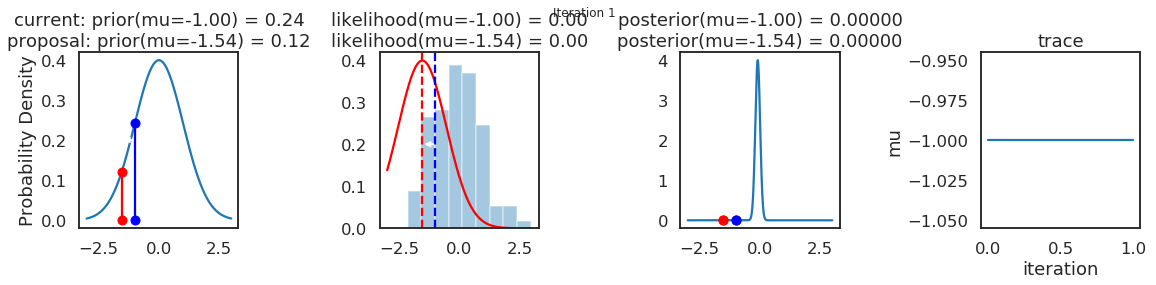

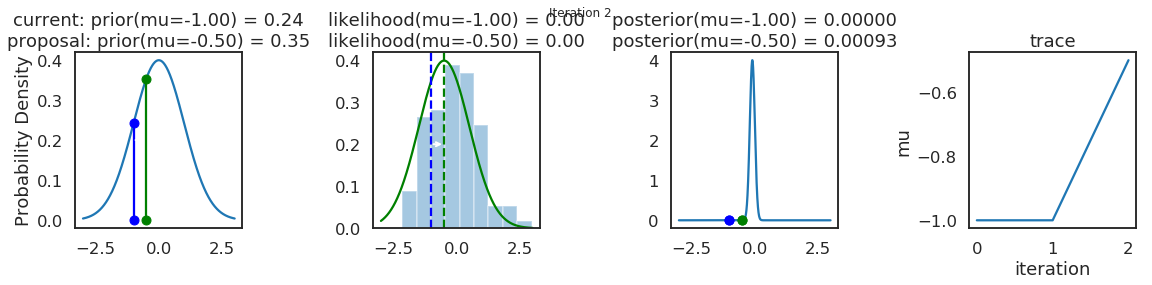

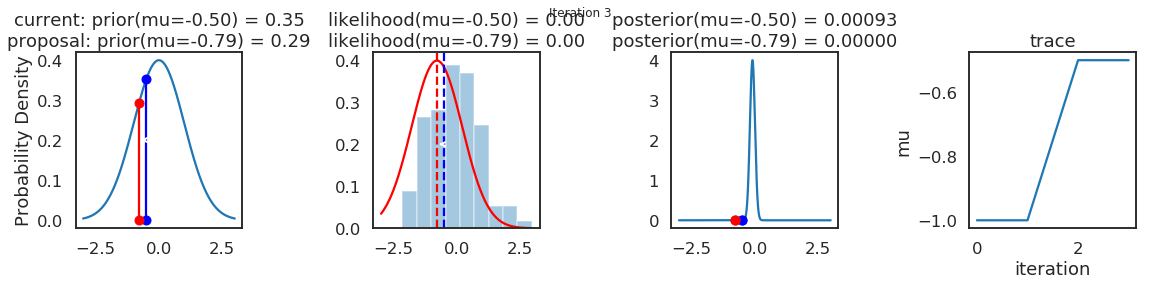

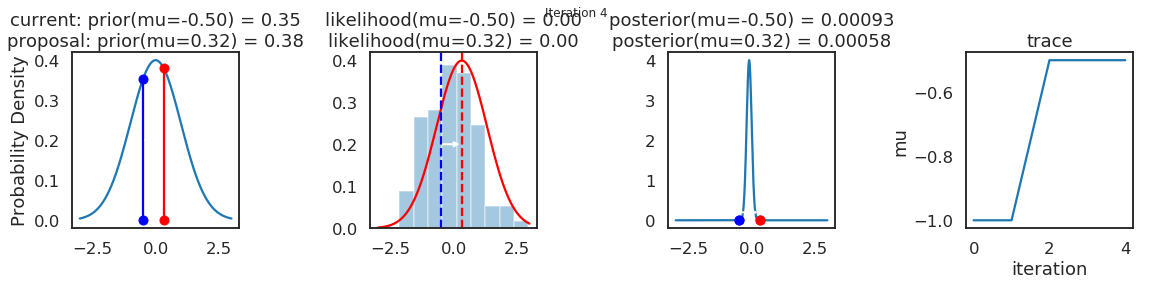

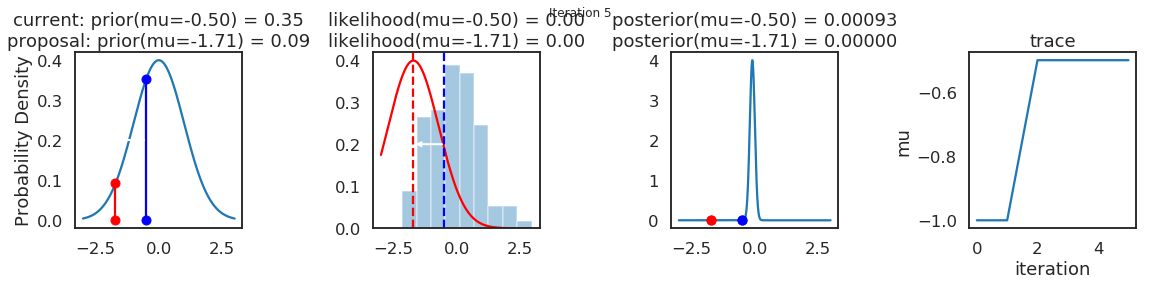

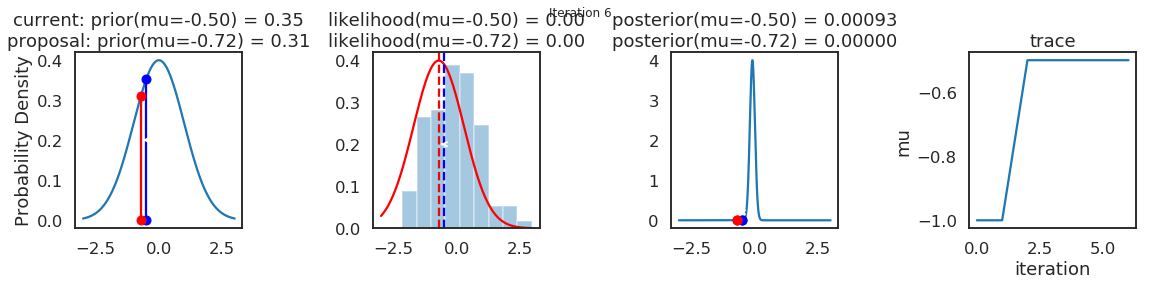

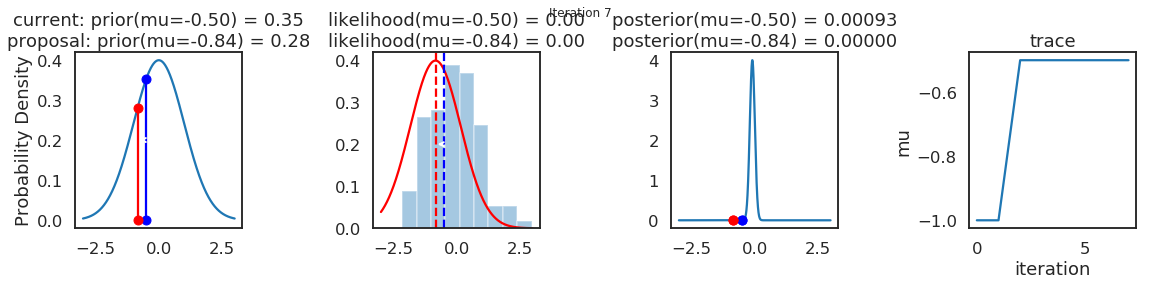

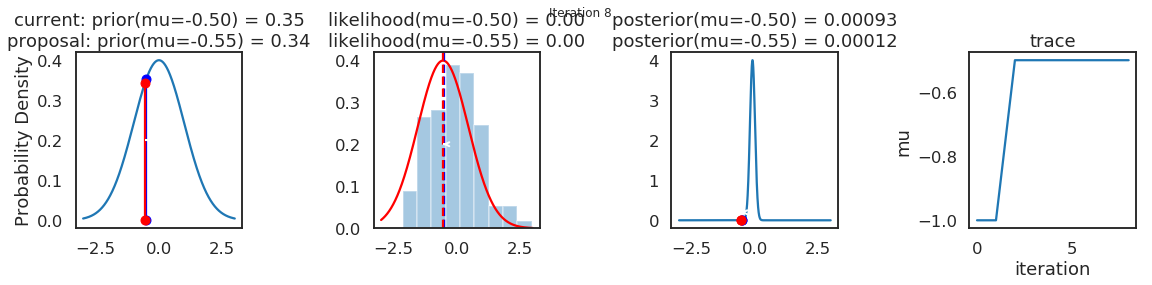

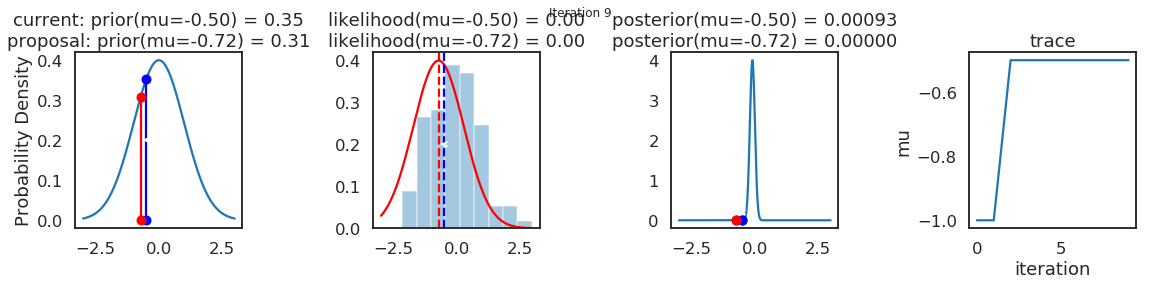

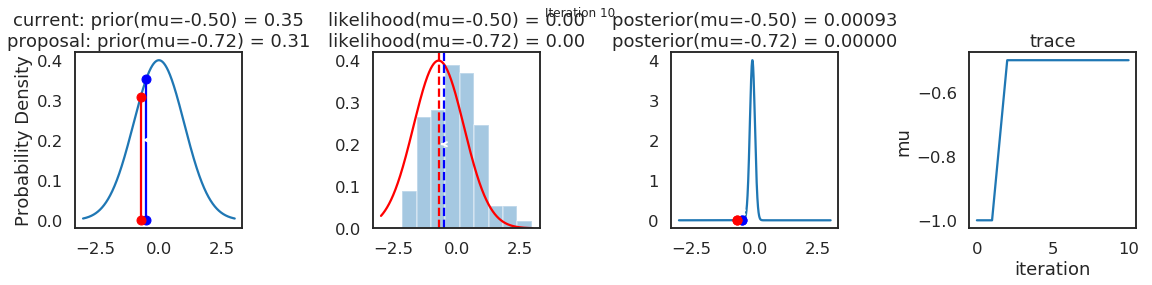

In [7]:
#ejecutamos para 25 iteraciones:

np.random.seed(123)
sampler(data, samples=10, mu_init=-1., plot=True);

Veamos ahora solo una realización de la cadena:

CPU times: user 15 s, sys: 56.1 ms, total: 15.1 s
Wall time: 15.1 s


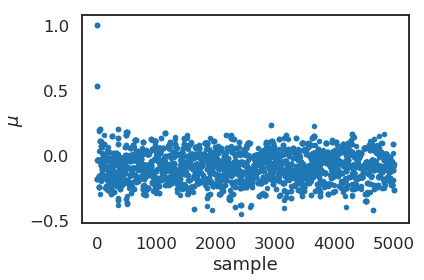

In [8]:
%time posterior = sampler(data, samples=5000, mu_init=1.)
fig, ax = plt.subplots()
ax.plot(posterior,'.')
_ = ax.set(xlabel='sample', ylabel='$\mu$')
plt.tight_layout()

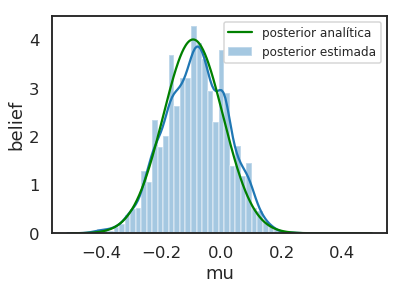

In [12]:
ax = plt.subplot()

sns.distplot(posterior[500:], ax=ax, label='posterior estimada')
x = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='posterior analítica')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend(fontsize=12);

## Efecto del ancho de la distribución de propuestas

Veamos cómo se comporta la cadena para un ancho igual a 0.01


CPU times: user 15.2 s, sys: 45.1 ms, total: 15.2 s
Wall time: 15.2 s


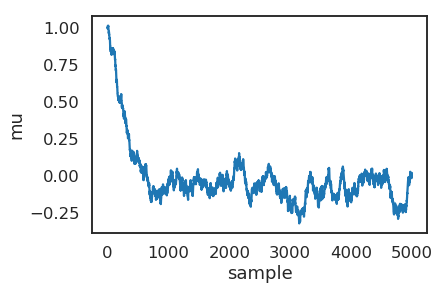

In [10]:
%time posterior_small = sampler(data, samples=5000, mu_init=1., proposal_width=.01)
fig, ax = plt.subplots()
ax.plot(posterior_small);
_ = ax.set(xlabel='sample', ylabel='mu');

Ahora para un ancho igual a 3

CPU times: user 15 s, sys: 43.1 ms, total: 15 s
Wall time: 15 s


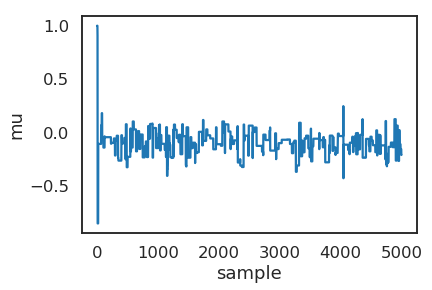

In [13]:
%time posterior_large = sampler(data, samples=5000, mu_init=1., proposal_width=3.)
fig, ax = plt.subplots()
ax.plot(posterior_large); plt.xlabel('sample'); plt.ylabel('mu');
_ = ax.set(xlabel='sample', ylabel='mu');

Para ambos anchos, las muestras generadas y sus correlaciones son:

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


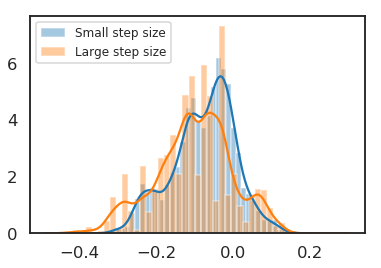

In [19]:
sns.distplot(posterior_small[1000:], label='Small step size')
sns.distplot(posterior_large[1000:], label='Large step size');
_ = plt.legend(fontsize=12);

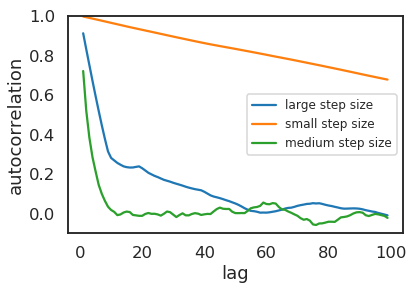

In [20]:
from pymc3.stats import autocorr
lags = np.arange(1, 100)
fig, ax = plt.subplots()
ax.plot(lags, [autocorr(np.array(posterior_large), l) for l in lags], label='large step size')
ax.plot(lags, [autocorr(np.array(posterior_small), l) for l in lags], label='small step size')
ax.plot(lags, [autocorr(np.array(posterior), l) for l in lags], label='medium step size')
ax.legend(loc=0,fontsize=12)
_ = ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1))

## Usar toolbox disponibles: PyMC3
veamos ahora que no es necesario inventar la rueda:

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu]
Sampling 4 chains: 100%|██████████| 602000/602000 [01:01<00:00, 9775.28draws/s] 
The number of effective samples is smaller than 25% for some parameters.
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


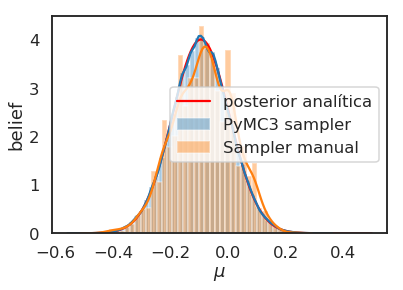

In [21]:
import pymc3 as pm

with pm.Model():
    mu = pm.Normal('mu', 0, 1)
    sigma = 1.
    returns = pm.Normal('returns', mu=mu, sd=sigma, observed=data)
    
    step = pm.Metropolis()
    trace = pm.sample(150000, step)
    
    
    
plt.plot(x, post, 'r', label='posterior analítica')
sns.distplot(trace[2000:]['mu'], label='PyMC3 sampler');
sns.distplot(posterior[500:], label='Sampler manual');
plt.xlabel('$\mu$')
plt.ylabel('belief')
plt.legend();

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


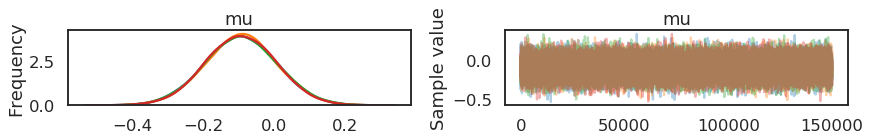

In [22]:
 _ = pm.traceplot(trace)